In [1]:
import os

import pandas as pd

datadir = os.path.join('data')
result_dir = os.path.join('results')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'spearman'
dataset_path = os.path.join(datadir, 'normalized_dataset.csv')
valid_path = os.path.join(datadir, f'valid_dataset.csv')
invalid_path = os.path.join(datadir, f'invalid_dataset.csv')

In [2]:
dataset = pd.read_csv(dataset_path, delimiter=';')
valid_df = pd.read_csv(valid_path, delimiter=';')
invalid_df = pd.read_csv(invalid_path, delimiter=';')


print(f"{len(dataset)} configs in dataset")

correlations = pd.read_csv(corr_path, delimiter=';')
correlations = correlations.rename(columns={"correlation": "spearman"})

print(f"{len(correlations)} correlations in matrix")

matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset.head(1010)

1001 configs in dataset
1004003 correlations in matrix


,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,coregistration/cost_function/mutual_information,signal_modeling/nuisance_regressors/comp_cor,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/algorithm/DARTEL,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation,spatial_normalization/template/MNI152_linear,spatial_normalization/bias_regularisation/extremely_light,...,spatial_normalization/template/MNI305,spatial_normalization/bias_fwhm,spatial_normalization/bias_regularisation/very_light,coregistration/source_target/anat_on_func,slice_timing_correction/ref_slice/first,spatial_normalization/interpolation/nearest_neighbour,signal_modeling/hrf/canonical,id,spearman_from_ref,spearman_from_mean
0,False,True,True,False,False,False,False,False,False,0,...,False,0,0,True,False,True,False,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0.467386,0.533488
1,True,False,False,False,True,False,True,False,False,0,...,False,0,0,False,False,False,False,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,0.624349,0.671276
2,True,True,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,3097a7dc41788499cf25575641e12f92017eaec464039b...,0.054786,0.265940
3,False,True,False,False,False,False,False,False,False,0,...,False,0,0,True,True,True,False,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,0.455374,0.584125
4,True,True,False,False,True,False,False,False,False,0,...,False,0,0,False,False,False,False,63bea197905677a189c165af71c8fc3933529cfb732832...,0.054786,0.265940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,False,False,False,False,False,False,False,False,False,0,...,False,0,0,False,True,False,False,91801a03dc14fd0a3028e8181828cd0d92bd12b830c86f...,0.123223,0.368549
997,False,False,False,False,True,False,False,False,False,0,...,False,0,0,True,False,True,False,ffcb718b2eaf9394c568665e65cb40e5b070ae63c2dd91...,0.070953,0.282691
998,False,False,False,False,False,False,True,False,False,0,...,False,0,0,True,False,False,False,c870f6446e080d90673cfac597ca16e081ea1b510ce78c...,0.138238,0.392617
999,True,True,False,False,True,False,True,False,False,0,...,False,0,0,True,False,False,False,315c85bdd9845ee4f5d15e689759ac1971849341a8b9b8...,0.588806,0.661417


In [3]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split


def predict_metric(path, target_metric, iteration, train_sizes=[], test_size=200):
    
    results_list = []
    
    ignored = [
        col for col in dataset.columns
        if col.endswith('from_ref') or col.endswith('from_mean')
    ]
    ignored.extend(['id'])
    
    test_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{test_size}_test_{iteration}.csv'), delimiter=';')
    y_test = test_ds[target_metric]
    X_test = test_ds.drop(columns=ignored).copy()
    
    for train_size in train_sizes:
        
        train_ds = pd.read_csv(os.path.join(path, f'sub_dataset_{train_size}_train_{iteration}.csv'), delimiter=';')
        
        y_train = train_ds[target_metric]
        X_train = train_ds.drop(columns=ignored).copy()

        regressor = DecisionTreeRegressor(random_state=42)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
    
        mape = mean_absolute_percentage_error(y_test, y_pred)
    
        features = X_train.columns
        importances = regressor.feature_importances_
        feat_importances = {feat: imp for feat, imp in zip(features, importances) if imp > 0.0}
    
        # Store the decision tree as text
        tree_rules = export_graphviz(
                regressor,
                out_file=None,
                feature_names=X_train.columns.values,
                filled=True,
                rounded=True,
                special_characters=True,
                leaves_parallel=True,
                proportion=True
            )
    
        results_list.append({
            'metric': target_metric,
            'train_size': train_size,
            'MAPE': mape,
            'decision_tree': tree_rules,
            'feature_importances': feat_importances,
            'nb_features': len(feat_importances)
        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results_list)

    return results_df

# Regression decision tree on full dataset
Given a configuration, try to predict the value of the correlation of this configuration result to
- the reference image
- the mean image

For prediction, means results are precomputed for each subset

In [4]:
metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('data/regression/full', metric, i, [80, 160, 240, 320, 400, 480, 560, 640, 720])
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
full_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
full_results_df.head(100)

,metric,train_size,MAPE,decision_tree,feature_importances,nb_features,iteration
0,spearman_from_ref,80,0.294307,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 2...,20,1
1,spearman_from_ref,160,0.133776,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
2,spearman_from_ref,240,0.122929,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
3,spearman_from_ref,320,0.117088,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 7...,24,1
4,spearman_from_ref,400,0.097469,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
...,...,...,...,...,...,...,...
95,spearman_from_ref,480,0.152954,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,6
96,spearman_from_ref,560,0.096845,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,6
97,spearman_from_ref,640,0.119061,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 2...,23,6
98,spearman_from_ref,720,0.123537,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,23,6


In [5]:
import graphviz

decision_tree = full_results_df.loc[
    (full_results_df['train_size'] == 720) &
    (full_results_df['iteration'] == 10) &
    (full_results_df['metric'] == 'spearman_from_ref'),
    'decision_tree'
].iloc[0]
graph = graphviz.Source(decision_tree)
graph.render(os.path.join(result_dir, f"full_regression"), format='svg')

'full_regression.svg'

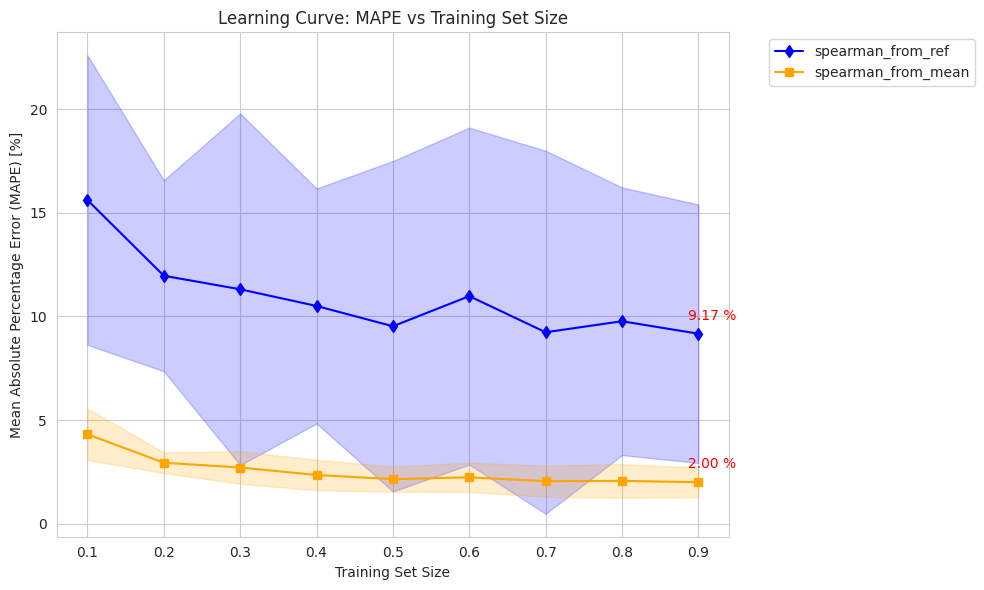

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = full_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean'][f'{corr_func}_from_ref']
std_mape_ref = pivot_df['std'][f'{corr_func}_from_ref']
mean_mape_mean = pivot_df['mean'][f'{corr_func}_from_mean']
std_mape_mean = pivot_df['std'][f'{corr_func}_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label=f'{corr_func}_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label=f'{corr_func}_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()


# Regression decision tree on valid dataset

In [8]:
metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('data/regression/valid', metric, i, [60, 120, 180, 240, 300, 360, 420, 480, 540], 151)
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
valid_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
valid_results_df.head(100)

,metric,train_size,MAPE,decision_tree,feature_importances,nb_features,iteration
0,spearman_from_ref,60,0.093094,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,20,1
1,spearman_from_ref,120,0.051308,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 1...,23,1
2,spearman_from_ref,180,0.061470,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
3,spearman_from_ref,240,0.079792,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
4,spearman_from_ref,300,0.060543,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,1
...,...,...,...,...,...,...,...
95,spearman_from_ref,360,0.044628,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,6
96,spearman_from_ref,420,0.040987,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,24,6
97,spearman_from_ref,480,0.078866,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 9...,24,6
98,spearman_from_ref,540,0.074311,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 8...,24,6


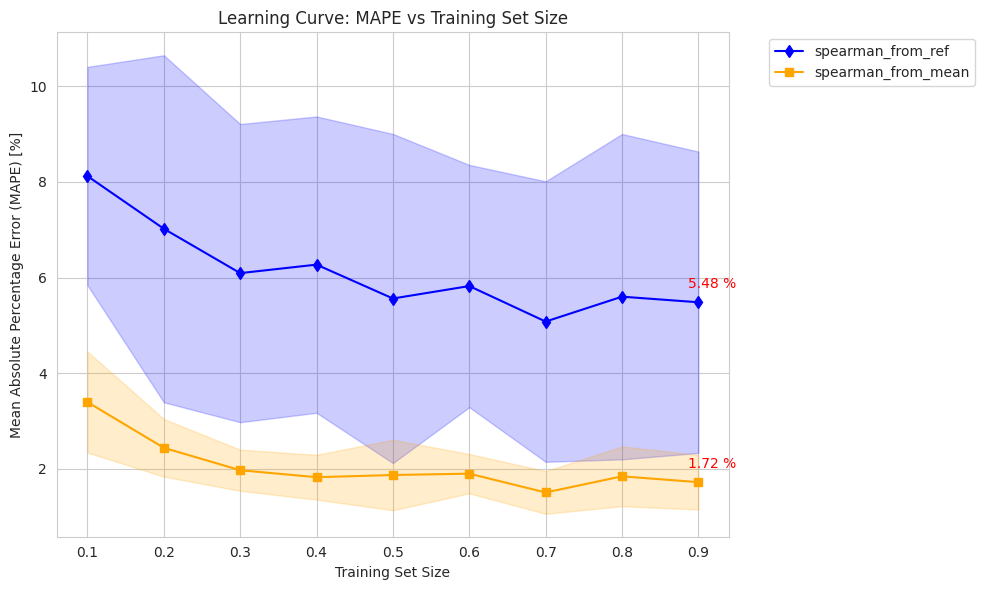

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = valid_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean'][f'{corr_func}_from_ref']
std_mape_ref = pivot_df['std'][f'{corr_func}_from_ref']
mean_mape_mean = pivot_df['mean'][f'{corr_func}_from_mean']
std_mape_mean = pivot_df['std'][f'{corr_func}_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label=f'{corr_func}_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label=f'{corr_func}_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()

# Regression decision tree on invalid dataset

In [10]:
metrics = [f'{corr_func}_from_ref', f'{corr_func}_from_mean']

all_results = []

for i in range(1, 11):
    for metric in metrics:
        results_df = predict_metric('data/regression/invalid', metric, i, [19, 39, 59, 79, 99, 119, 139, 159, 179], 50)
        results_df['iteration'] = i
        all_results.append(results_df)

# Concatenate all results into a single DataFrame
invalid_results_df = pd.concat(all_results, ignore_index=True)

# Display the final DataFrame
invalid_results_df.head(100)

,metric,train_size,MAPE,decision_tree,feature_importances,nb_features,iteration
0,spearman_from_ref,19,0.179673,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/fi...,9,1
1,spearman_from_ref,39,0.111847,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,14,1
2,spearman_from_ref,59,0.107465,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 8...,17,1
3,spearman_from_ref,79,0.100465,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,19,1
4,spearman_from_ref,99,0.121594,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,20,1
...,...,...,...,...,...,...,...
95,spearman_from_ref,119,0.059274,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,21,6
96,spearman_from_ref,139,0.055770,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,21,6
97,spearman_from_ref,159,0.050080,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,21,6
98,spearman_from_ref,179,0.048115,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/middle': 0...,20,6


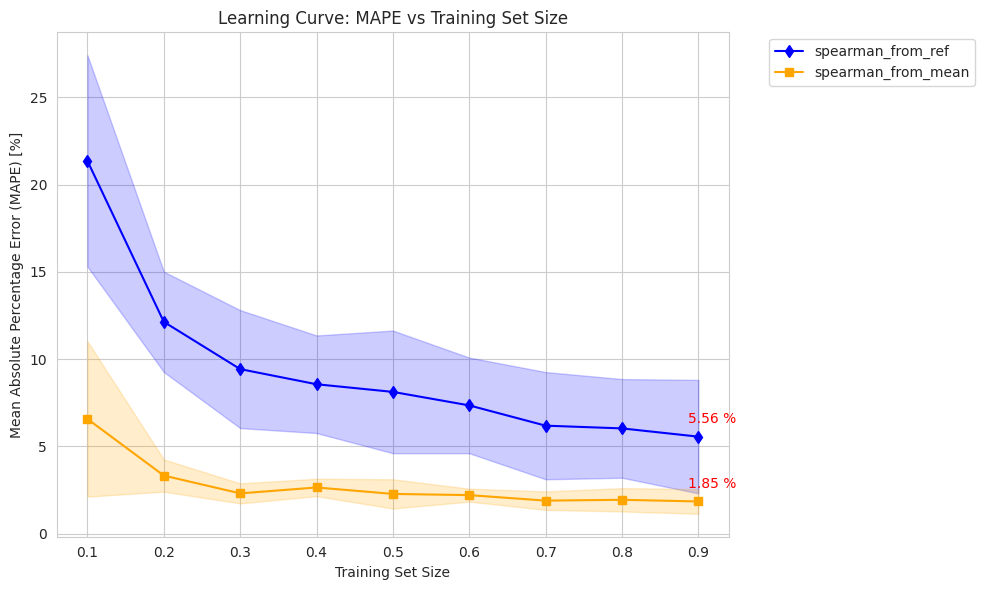

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

grouped = invalid_results_df.groupby(['metric', 'train_size'])['MAPE'].agg(['mean', 'std']).reset_index()
pivot_df = grouped.pivot(index='train_size', columns='metric', values=['mean', 'std'])

mean_mape_ref = pivot_df['mean'][f'{corr_func}_from_ref']
std_mape_ref = pivot_df['std'][f'{corr_func}_from_ref']
mean_mape_mean = pivot_df['mean'][f'{corr_func}_from_mean']
std_mape_mean = pivot_df['std'][f'{corr_func}_from_mean']

# Plotting
plt.figure(figsize=(10, 6))
train_sizes = np.linspace(0.1, 0.9, 9)

# Plot for pearson_from_ref
plt.plot(
    train_sizes,
    mean_mape_ref * 100,  # Multiply by 100 to get percentage
    marker='d',
    label=f'{corr_func}_from_ref',
    color='blue'
)
plt.fill_between(
    train_sizes,
    (mean_mape_ref - std_mape_ref) * 100,  # Multiply by 100
    (mean_mape_ref + std_mape_ref) * 100,  # Multiply by 100
    alpha=0.2,
    color='blue'
)
plt.annotate(
    f'{mean_mape_ref.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_ref.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Plot for pearson_from_mean
plt.plot(
    train_sizes,
    mean_mape_mean * 100,  # Multiply by 100 to get percentage
    marker='s',
    label=f'{corr_func}_from_mean',
    color='orange'
)
plt.fill_between(
    train_sizes,
    (mean_mape_mean - std_mape_mean) * 100,  # Multiply by 100
    (mean_mape_mean + std_mape_mean) * 100,  # Multiply by 100
    alpha=0.2,
    color='orange'
)
plt.annotate(
    f'{mean_mape_mean.iloc[-1] * 100:.2f} %',  # Multiply by 100
    (train_sizes[-1], mean_mape_mean.iloc[-1] * 100),  # Multiply by 100
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=10,
    color='red'
)

# Place the legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Percentage Error (MAPE) [%]')
plt.title('Learning Curve: MAPE vs Training Set Size')
plt.grid(True)
plt.tight_layout()
plt.show()